# Дипломный проект. Прогнозирование температуры стали

С целью оптимизации производственных расходов металлургический комбинат решил уменьшить потребление электроэнергии на этапе обработки стали. Необходимо построить модель, которая будет предсказывать температуру стали.

## Описание обработки стали

Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша.

Из сплава выводится сера (десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав, добавляя куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат.

Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем сплав перемешивают и снова проводят измерения. Такой цикл повторяется до тех пор, пока не будет достигнут нужный химический состав сплава и оптимальная температура плавки.

Дальше расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (англ. slab, «плита»).

## Описание данных

Данные хранятся в таблицах в базе данных PostgreSQL:
- `steel.data_arc` — данные об электродах;
- `steel.data_bulk` — данные о подаче сыпучих материалов (объём);
- `steel.data_bulk_time` — данные о подаче сыпучих материалов (время);
- `steel.data_gas` — данные о продувке сплава газом;
- `steel.data_temp` — результаты измерения температуры;
- `steel.data_wire` — данные о проволочных материалах (объём);
- `steel.data_wire_time` — данные о проволочных материалах (время).

## Подключение к базе данных PostgreSQL. Загрузка SQL-таблиц

In [1]:
# установка дополнительных пакетов
!pip install skfeature-chappers optuna phik

You should consider upgrading via the '/home/troflianina/.pyenv/versions/3.9.5/envs/nlp/bin/python3.9 -m pip install --upgrade pip' command.
You should consider upgrading via the '/home/troflianina/.pyenv/versions/3.9.5/envs/nlp/bin/python3.9 -m pip install --upgrade pip' command.


In [2]:
import warnings
from datetime import timedelta

import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
import seaborn as sns
import phik

from optuna.integration import OptunaSearchCV
from phik.report import plot_correlation_matrix, correlation_report
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import MinMaxScaler
from sqlalchemy import create_engine
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

2023-01-10 21:10:22.290236: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-10 21:10:22.375373: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-01-10 21:10:22.375390: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-01-10 21:10:22.933264: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

In [3]:
warnings.filterwarnings('ignore')

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

SEED=123

In [4]:
# подключение к базе данных
# параметры для подключения к БД скрыты в соответствии с офертой Яндекс.Практикума
db_config = {
    'user': '', # имя пользователя
    'pwd': '', # пароль
    'host': '',
    'port':  # порт подключения
    'db': '' # название базы данных
}

connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db'],
)

In [5]:
# создание подключения
engine = create_engine(connection_string)

Далее загружу таблицы из базы данных в pandas-датафреймы:

In [6]:
# данные об электродах
query_steel_data_arc = '''
SELECT *
FROM steel.data_arc;
'''

steel_arc = pd.read_sql_query(query_steel_data_arc, con=engine) 

In [7]:
# данные о подаче сыпучих материалов(объем)
query_steel_data_bulk = '''
SELECT *
FROM steel.data_bulk;
'''

steel_bulk = pd.read_sql_query(query_steel_data_bulk, con=engine)

In [8]:
# данные о подаче сыпучих материалов(время)
query_steel_data_bulk_time = '''
SELECT *
FROM steel.data_bulk_time;
'''

steel_bulk_time = pd.read_sql_query(query_steel_data_bulk_time, con=engine)

In [9]:
# данные о продувке сплава газом
query_steel_data_gas = '''
SELECT *
FROM steel.data_gas;
'''

steel_gas = pd.read_sql_query(query_steel_data_gas, con=engine)

In [10]:
# результаты измерения температуры
query_steel_data_temp = '''
SELECT *
FROM steel.data_temp;
'''

steel_temp = pd.read_sql_query(query_steel_data_temp, con=engine)

In [11]:
# данные о проволочных материалах(объём)
query_steel_data_wire = '''
SELECT *
FROM steel.data_wire;
'''

steel_wire = pd.read_sql_query(query_steel_data_wire, con=engine)

In [12]:
# данные о проволочных материалах(время)
query_steel_data_wire_time = '''
SELECT *
FROM steel.data_wire_time;
'''

steel_wire_time = pd.read_sql_query(query_steel_data_wire_time, con=engine)

**Вывод:** создано подключение к базе данных PostgreSQL и загружены таблицы с описанием обработки стали.

### Первичное исследование таблиц

In [13]:
# получение общей информации о таблицах
def get_info(df):
    display(df.shape)
    print("Количество партий:", len(df['key'].unique()))
    display(df.isna().sum())
    display(df.head())
    display(df.info())
    display(df.describe())

**Описание данных таблицы `steel_arc`:**
- `key` — номер партии,
- `BeginHeat` — время начала нагрева,
- `EndHeat` — время окончания нагрева,
- `ActivePower` — значение активной мощности,
- `ReactivePower` — значение реактивной мощности.

In [14]:
get_info(steel_arc)

(14876, 5)

Количество партий: 3214


key              0
BeginHeat        0
EndHeat          0
ActivePower      0
ReactivePower    0
dtype: int64

,key,BeginHeat,EndHeat,ActivePower,ReactivePower
0,1,11:02:14,11:06:02,0.976059,0.687084
1,1,11:07:28,11:10:33,0.805607,0.520285
2,1,11:11:44,11:14:36,0.744363,0.498805
3,1,11:18:14,11:24:19,1.659363,1.062669
4,1,11:26:09,11:28:37,0.692755,0.414397


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   key            14876 non-null  int64  
 1   BeginHeat      14876 non-null  object 
 2   EndHeat        14876 non-null  object 
 3   ActivePower    14876 non-null  float64
 4   ReactivePower  14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


None

,key,ActivePower,ReactivePower
count,14876.000000,14876.000000,14876.000000
mean,1615.220422,0.670441,0.452592
std,934.571502,0.408159,5.878702
min,1.000000,0.030002,-715.504924
25%,806.000000,0.395297,0.290991
50%,1617.000000,0.555517,0.415962
75%,2429.000000,0.857034,0.637371
max,3241.000000,3.731596,2.676388


**Описание данных таблицы `steel_bulk`:**
- `key` — номер партии,
- `Bulk1 … Bulk15` — объём подаваемого материала.

In [15]:
get_info(steel_bulk)

(3129, 16)

Количество партий: 3129


key           0
Bulk 1     2877
Bulk 2     3107
Bulk 3     1831
Bulk 4     2115
Bulk 5     3052
Bulk 6     2553
Bulk 7     3104
Bulk 8     3128
Bulk 9     3110
Bulk 10    2953
Bulk 11    2952
Bulk 12     679
Bulk 13    3111
Bulk 14     323
Bulk 15     881
dtype: int64

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


None

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
count,3129.000000,252.000000,22.000000,1298.000000,1014.000000,77.000000,576.000000,25.000000,1.0,19.000000,176.000000,177.000000,2450.000000,18.000000,2806.000000,2248.000000
mean,1624.383509,39.242063,253.045455,113.879045,104.394477,107.025974,118.925347,305.600000,49.0,76.315789,83.284091,76.819209,260.471020,181.111111,170.284747,160.513345
std,933.337642,18.277654,21.180578,75.483494,48.184126,81.790646,72.057776,191.022904,NaN,21.720581,26.060347,59.655365,120.649269,46.088009,65.868652,51.765319
min,1.000000,10.000000,228.000000,6.000000,12.000000,11.000000,17.000000,47.000000,49.0,63.000000,24.000000,8.000000,53.000000,151.000000,16.000000,1.000000
25%,816.000000,27.000000,242.000000,58.000000,72.000000,70.000000,69.750000,155.000000,49.0,66.000000,64.000000,25.000000,204.000000,153.250000,119.000000,105.000000
50%,1622.000000,31.000000,251.500000,97.500000,102.000000,86.000000,100.000000,298.000000,49.0,68.000000,86.500000,64.000000,208.000000,155.500000,151.000000,160.000000
75%,2431.000000,46.000000,257.750000,152.000000,133.000000,132.000000,157.000000,406.000000,49.0,70.500000,102.000000,106.000000,316.000000,203.500000,205.750000,205.000000
max,3241.000000,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.0,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000


**Описание данных таблицы `steel_bulk_time`:**
- `key` — номер партии,
- `Bulk1 … Bulk15` — время подачи материала.

In [16]:
get_info(steel_bulk_time)

(3129, 16)

Количество партий: 3129


key           0
Bulk 1     2877
Bulk 2     3107
Bulk 3     1831
Bulk 4     2115
Bulk 5     3052
Bulk 6     2553
Bulk 7     3104
Bulk 8     3128
Bulk 9     3110
Bulk 10    2953
Bulk 11    2952
Bulk 12     679
Bulk 13    3111
Bulk 14     323
Bulk 15     881
dtype: int64

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,None,None,None,11:21:30,None,None,None,None,None,None,None,11:03:52,None,11:03:52,11:03:52
1,2,None,None,None,11:46:38,None,None,None,None,None,None,None,11:40:20,None,11:40:20,11:40:20
2,3,None,None,None,12:31:06,None,None,None,None,None,None,None,12:09:40,None,12:09:40,12:09:40
3,4,None,None,None,12:48:43,None,None,None,None,None,None,None,12:41:24,None,12:41:24,12:41:24
4,5,None,None,None,13:18:50,None,None,None,None,None,None,None,13:12:56,None,13:12:56,13:12:56


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


None

,key
count,3129.000000
mean,1624.383509
std,933.337642
min,1.000000
25%,816.000000
50%,1622.000000
75%,2431.000000
max,3241.000000


**Описание данных таблицы `steel_gas`:**
- `key` — номер партии,
- `gas` — объём подаваемого газа.

In [17]:
get_info(steel_gas)

(3239, 2)

Количество партий: 3239


key    0
gas    0
dtype: int64

,key,gas
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   gas     3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


None

,key,gas
count,3239.000000,3239.000000
mean,1621.861377,11.002062
std,935.386334,6.220327
min,1.000000,0.008399
25%,812.500000,7.043089
50%,1622.000000,9.836267
75%,2431.500000,13.769915
max,3241.000000,77.995040


**Описание данных таблицы `steel_temp`:**
- `key` — номер партии,
- `MesaureTime` — время замера,
- `Temperature` — значение температуры.

In [18]:
get_info(steel_temp)

(15907, 3)

Количество партий: 3216


key               0
MesaureTime       0
Temperature    2901
dtype: int64

,key,MesaureTime,Temperature
0,1,11:16:18,1571.0
1,1,11:25:53,1604.0
2,1,11:29:11,1618.0
3,1,11:30:01,1601.0
4,1,11:30:39,1613.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   key          15907 non-null  int64  
 1   MesaureTime  15907 non-null  object 
 2   Temperature  13006 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 372.9+ KB


None

,key,Temperature
count,15907.000000,13006.000000
mean,1607.880870,1591.840920
std,942.212073,21.375851
min,1.000000,1191.000000
25%,790.000000,1581.000000
50%,1618.000000,1591.000000
75%,2427.000000,1601.000000
max,3241.000000,1705.000000


**Описание данных таблицы `steel_wire`:**
- `key` — номер партии,
- `Wire1 … Wire15` — объём подаваемых проволочных материалов.

In [19]:
get_info(steel_wire)

(3081, 10)

Количество партий: 3081


key          0
Wire 1      26
Wire 2    2002
Wire 3    3018
Wire 4    3067
Wire 5    3080
Wire 6    3008
Wire 7    3070
Wire 8    3062
Wire 9    3052
dtype: int64

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


None

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
count,3081.000000,3055.000000,1079.000000,63.000000,14.000000,1.000,73.000000,11.000000,19.000000,29.000000
mean,1623.426485,100.895853,50.577323,189.482681,57.442841,15.132,48.016974,10.039007,53.625193,34.155752
std,932.996726,42.012518,39.320216,99.513444,28.824667,NaN,33.919845,8.610584,16.881728,19.931616
min,1.000000,1.918800,0.030160,0.144144,24.148801,15.132,0.034320,0.234208,45.076721,4.622800
25%,823.000000,72.115684,20.193680,95.135044,40.807002,15.132,25.053600,6.762756,46.094879,22.058401
50%,1619.000000,100.158234,40.142956,235.194977,45.234282,15.132,42.076324,9.017009,46.279999,30.066399
75%,2434.000000,126.060484,70.227558,276.252014,76.124619,15.132,64.212723,11.886057,48.089603,43.862003
max,3241.000000,330.314424,282.780152,385.008668,113.231044,15.132,180.454575,32.847674,102.762401,90.053604


**Описание данных таблицы `steel_wire_time`:**
- `key` — номер партии,
- `Wire1 … Wire15` — время подачи проволочных материалов.

In [20]:
get_info(steel_wire_time)

(3081, 10)

Количество партий: 3081


key          0
Wire 1      26
Wire 2    2002
Wire 3    3018
Wire 4    3067
Wire 5    3080
Wire 6    3008
Wire 7    3070
Wire 8    3062
Wire 9    3052
dtype: int64

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,11:11:41,None,None,None,None,None,None,None,None
1,2,11:46:10,None,None,None,None,None,None,None,None
2,3,12:13:47,None,None,None,None,None,None,None,None
3,4,12:48:05,None,None,None,None,None,None,None,None
4,5,13:18:15,13:32:06,None,None,None,None,None,None,None


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


None

,key
count,3081.000000
mean,1623.426485
std,932.996726
min,1.000000
25%,823.000000
50%,1619.000000
75%,2434.000000
max,3241.000000


### Вывод

Получена общая информация о таблицах:
- количество таблиц соответствует условию задачи;
- каждая таблица имеет общий ключ `key`  - номер партии, но при этом, количество уникальных партий в каждой таблице разное, значит, информация о небольшой части партий отсутствует; далее при объединении таблиц буду использовать `INNER JOIN`, чтобы учитывать только те партии, информация о которых есть во всех таблицах;
- в таблицах с данными о проволочных и сыпучих материалах есть большое количество пропусков, что говорит о том, что не на каждой итерации партии использовались добавки;
- также наблюдается разное написание колонок: приведу все названия к "змеиному_регистру" для удобства обращения к столбцам таблиц;
- в таблице с данными об электродах есть отрицательные значения реактивной мощности.

*Краткая справка из Википедии: реактивная мощность может быть как положительной величиной (если нагрузка имеет активно-индуктивный характер), так и отрицательной (если нагрузка имеет активно-ёмкостный характер). Данное обстоятельство подчёркивает тот факт, что реактивная мощность не участвует в работе электрического тока.*

## Статистический анализ

**Для таблицы `steel_temp` посчитаю, сколько времени прошло между первым и последним замером температуры.**

In [21]:
steel_temp['MesaureTime'] = pd.to_timedelta(steel_temp['MesaureTime'].astype(str))

In [22]:
grouped_temp = steel_temp.groupby(by='key', axis=0)

In [23]:
grouped_temp = grouped_temp['MesaureTime'].agg(first_time='first', last_time='last')

Есть партии, где время первого и последнего измерения находятся в разных днях:

In [24]:
grouped_temp.query('first_time > last_time').head()

,first_time,last_time
key,,
18,0 days 23:22:18,0 days 00:08:29
44,0 days 22:13:44,0 days 01:13:17
45,0 days 23:06:36,0 days 00:26:13
46,0 days 23:54:43,0 days 03:14:53
74,0 days 23:51:01,0 days 00:19:42


Такие данные нельзя вытащить из БД оконной функцией, поэтому в дальнейшем объединенном запросе буду исключать такие партии.

In [25]:
excluded_keys = grouped_temp.query('first_time > last_time').index.tolist()
len(excluded_keys)

71

In [26]:
def calc_diff_time(row):
    if row['first_time'] > row['last_time']:
        return timedelta(hours=24) - row['first_time'] + row['last_time']
    else:
        return row['last_time'] - row['first_time']

In [27]:
grouped_temp['diff_time'] = grouped_temp.apply(calc_diff_time, axis=1)

In [28]:
grouped_temp.head()

,first_time,last_time,diff_time
key,,,
1,0 days 11:16:18,0 days 11:30:39,0 days 00:14:21
2,0 days 11:37:27,0 days 11:59:12,0 days 00:21:45
3,0 days 12:13:17,0 days 12:34:57,0 days 00:21:40
4,0 days 12:52:57,0 days 12:59:25,0 days 00:06:28
5,0 days 13:23:19,0 days 13:36:01,0 days 00:12:42


In [29]:
# статистические показатели
grouped_temp.describe()

,first_time,last_time,diff_time
count,3216,3216,3216
mean,0 days 11:50:42.828358208,0 days 11:49:35.227300995,0 days 00:30:39.861629353
std,0 days 06:55:35.136477157,0 days 06:55:37.870369707,0 days 00:20:46.950298194
min,0 days 00:00:14,0 days 00:00:27,0 days 00:00:00
25%,0 days 05:54:05,0 days 05:54:50,0 days 00:19:37
50%,0 days 11:40:14.500000,0 days 11:38:13.500000,0 days 00:26:21
75%,0 days 17:48:20.750000,0 days 17:44:37.500000,0 days 00:37:15
max,0 days 23:59:39,0 days 23:59:54,0 days 06:32:17


In [30]:
grouped_temp.query('first_time == last_time')

,first_time,last_time,diff_time
key,,,
195,0 days 14:10:23,0 days 14:10:23,0 days
279,0 days 23:07:28,0 days 23:07:28,0 days


В таблице есть две партии, в которых было только одно измерение: не буду их учитывать при вычислении статистических показателей.

In [31]:
grouped_temp.query('first_time != last_time').describe()

,first_time,last_time,diff_time
count,3214,3214,3214
mean,0 days 11:50:27.587118855,0 days 11:49:19.943995021,0 days 00:30:41.006533914
std,0 days 06:55:32.164183026,0 days 06:55:34.858687094,0 days 00:20:46.492873846
min,0 days 00:00:14,0 days 00:00:27,0 days 00:03:17
25%,0 days 05:53:07,0 days 05:54:04,0 days 00:19:38.250000
50%,0 days 11:39:41,0 days 11:37:30,0 days 00:26:23
75%,0 days 17:48:09.750000,0 days 17:44:29.250000,0 days 00:37:15
max,0 days 23:59:39,0 days 23:59:54,0 days 06:32:17


***Анализ:***
- после группировки наблюдается 3216 номеров партии нагрева стали;
- в среднем для партий, между первым и последним замером температуры стали прошло 30 минут, минимальная разность - 3 минуты 17 секунд, а максимальная - 6 часов 32 минуты.

Также хочу отметить, что для наиболее корректного анализа необходимо проставлять дату замера температуры, а не только время.

**Далее исследую таблицу `steel_arc` и вычислю:**
- суммарное время нагрева электродами, то есть сумму значений по всем промежуткам между запусками нагрева электродами;
- количество запусков нагрева электродами;
- среднее соотношение потребления активной и реактивной мощности.

In [32]:
steel_arc['BeginHeat'] = pd.to_timedelta(steel_arc['BeginHeat'].astype(str))
steel_arc['EndHeat'] = pd.to_timedelta(steel_arc['EndHeat'].astype(str))

В этой таблице так же есть строки, где время первого и последнего измерения находятся в разных днях и для корректного вычисления разницы буду использовать функцию:

In [33]:
def calc_diff_time_arc(row):
    if row['BeginHeat'] > row['EndHeat']:
        return timedelta(hours=24) - row['BeginHeat'] + row['EndHeat']
    else:
        return row['EndHeat'] - row['BeginHeat']

In [34]:
steel_arc['diff_time_arc'] = steel_arc.apply(calc_diff_time_arc, axis=1)

In [35]:
steel_arc['ratio_power'] = steel_arc['ActivePower'] / steel_arc['ReactivePower']

In [36]:
grouped_arc = steel_arc.groupby(by='key', axis=0)['diff_time_arc'].agg(total_time='sum', count_arc='count')

In [37]:
grouped_arc.describe()

,total_time,count_arc
count,3214,3214.000000
mean,0 days 00:13:14.579029247,4.628500
std,0 days 00:05:32.448622113,1.608647
min,0 days 00:00:57,1.000000
25%,0 days 00:09:31,4.000000
50%,0 days 00:12:50,4.000000
75%,0 days 00:16:23,6.000000
max,0 days 01:09:49,16.000000


In [38]:
mean_ratio_power = steel_arc.groupby(by='key', axis=0)['ratio_power'].mean()
mean_ratio_power.describe()

count    3214.000000
mean        1.357452
std         0.132824
min         0.676106
25%         1.292892
50%         1.370550
75%         1.438292
max         1.782164
Name: ratio_power, dtype: float64

***Анализ:***
- в одной партии встречается от 1 до 16 итераций, а среднее количество итераций нагрева - 5;
- среднее время нагрева электродами составляет 13 минут; минимальное время - 57 секунд; максимальное - 1 час 10 минут;
- вычислено среднее соотношение потребления активной и реактивной мощности, но для создания модели рассчитаю полную мощность, так как на мой взгляд, этот признак улучшит обобщающую способность модели.

## Создание датафрейма для предсказания температуры стали

Проведу первичный отбор признаков, необходимых для обучения модели предсказания температуры стали, сразу агрегируя некоторые из них.

**Признаки для модели:**
- номер партии `key`, полученный с помощью группировки;
- количество итераций в партии `count_iteration` - на мой взгляд, этот признак может быть значимым для модели, так как лучше уменьшать количество итераций нагрева в одной партии, чтобы уменьшить электроэнергию на этапе обработки стали;
- суммарное время нагрева электродами `arc_total_time`;
- значение полной мощности `total_power`;
- объём подаваемого материала `volume_bulk_1 ... volume_bulk_15`;
- объём подаваемого газа `volume_gas`;
- **целевой признак** - значение температуры `temperature`, взятое на последней итерации в партии; если была всего одна итерация с одним замером температуры, то такие строки не буду включать в датасет;
- значение температуры стали после первого нагрева `first_temperature`;
- объём подаваемых проволочных материалов `volume_wire_1 ... volume_wire_9`.

В итоговый датафрейм не включила столбцы с временем подачи материала, временем замера температуры и временем подачи проволочных материалов.

In [39]:
query = f'''
WITH a AS
(SELECT key, 
        count(*) AS count_iteration,
        SUM(CASE
            WHEN "BeginHeat" > "EndHeat" THEN INTERVAL '24 hour' - "BeginHeat"::INTERVAL + "EndHeat"::INTERVAL
            ELSE "EndHeat" - "BeginHeat"
            END
        ) AS arc_total_time,
        ROUND(SUM(SQRT(POWER("ActivePower", 2) + POWER("ReactivePower", 2))), 2) AS total_power
FROM steel.data_arc
GROUP BY key
ORDER BY key),

b AS (SELECT key, 
             SUM("Bulk 1") AS volume_bulk_1, SUM("Bulk 2") AS volume_bulk_2, SUM("Bulk 3") AS volume_bulk_3,
             SUM("Bulk 4") AS volume_bulk_4, SUM("Bulk 5") AS volume_bulk_5, SUM("Bulk 6") AS volume_bulk_6,
             SUM("Bulk 7") AS volume_bulk_7, SUM("Bulk 8") AS volume_bulk_8, SUM("Bulk 9") AS volume_bulk_9,
             SUM("Bulk 10") AS volume_bulk_10, SUM("Bulk 11") AS volume_bulk_11, SUM("Bulk 12") AS volume_bulk_12,
             SUM("Bulk 13") AS volume_bulk_13, SUM("Bulk 14") AS volume_bulk_14, SUM("Bulk 15") AS volume_bulk_15
      FROM steel.data_bulk
      GROUP BY key
      ORDER BY key),

g AS (SELECT key, ROUND(SUM("gas"), 4) AS volume_gas
      FROM steel.data_gas
      GROUP BY key
      ORDER BY key),

t AS (SELECT DISTINCT key,
        LAST_VALUE("Temperature") OVER(PARTITION BY key ORDER BY "MesaureTime" 
        RANGE BETWEEN CURRENT ROW AND UNBOUNDED FOLLOWING) AS temperature,
        FIRST_VALUE("Temperature") OVER(PARTITION BY key ORDER BY "MesaureTime") AS first_temperature
        FROM steel.data_temp
        WHERE key not in %(excluded_keys)s
        ORDER BY key),

w AS (SELECT key,
            SUM("Wire 1") AS volume_wire_1, SUM("Wire 2") AS volume_wire_2, SUM("Wire 3") AS volume_wire_3,
            SUM("Wire 4") AS volume_wire_4, SUM("Wire 5") AS volume_wire_5, SUM("Wire 6") AS volume_wire_6,
            SUM("Wire 7") AS volume_wire_7, SUM("Wire 8") AS volume_wire_8, SUM("Wire 9") AS volume_wire_9
FROM steel.data_wire
GROUP BY key
ORDER BY key)


SELECT *
FROM a
INNER JOIN b ON b.key = a.key
INNER JOIN g ON g.key = b.key
INNER JOIN t ON t.key = g.key
INNER JOIN w ON w.key = t.key
'''

In [40]:
steel = pd.read_sql_query(query, params={'excluded_keys': tuple(excluded_keys)}, con=engine)

In [41]:
# удаление дублирующихся столбцов
steel = steel.loc[:, ~steel.columns.duplicated()]

In [42]:
get_info(steel)

(2951, 31)

Количество партий: 2951


key                     0
count_iteration         0
arc_total_time          0
total_power             0
volume_bulk_1        2706
volume_bulk_2        2929
volume_bulk_3        1686
volume_bulk_4        1963
volume_bulk_5        2878
volume_bulk_6        2397
volume_bulk_7        2927
volume_bulk_8        2950
volume_bulk_9        2933
volume_bulk_10       2776
volume_bulk_11       2778
volume_bulk_12        656
volume_bulk_13       2936
volume_bulk_14        308
volume_bulk_15        772
volume_gas              0
temperature           676
first_temperature       0
volume_wire_1          25
volume_wire_2        1919
volume_wire_3        2889
volume_wire_4        2937
volume_wire_5        2950
volume_wire_6        2880
volume_wire_7        2940
volume_wire_8        2933
volume_wire_9        2927
dtype: int64

,key,count_iteration,arc_total_time,total_power,volume_bulk_1,volume_bulk_2,volume_bulk_3,volume_bulk_4,volume_bulk_5,volume_bulk_6,volume_bulk_7,volume_bulk_8,volume_bulk_9,volume_bulk_10,volume_bulk_11,volume_bulk_12,volume_bulk_13,volume_bulk_14,volume_bulk_15,volume_gas,temperature,first_temperature,volume_wire_1,volume_wire_2,volume_wire_3,volume_wire_4,volume_wire_5,volume_wire_6,volume_wire_7,volume_wire_8,volume_wire_9
0,1,5,0 days 00:18:18,5.83,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0,29.7500,1613.0,1571.0,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,4,0 days 00:13:31,3.65,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0,12.5556,1602.0,1581.0,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,5,0 days 00:10:55,2.99,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0,28.5548,1599.0,1596.0,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,4,0 days 00:12:21,3.81,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0,18.8412,1625.0,1601.0,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,4,0 days 00:14:29,4.04,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0,5.4137,1602.0,1576.0,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2951 entries, 0 to 2950
Data columns (total 31 columns):
 #   Column             Non-Null Count  Dtype          
---  ------             --------------  -----          
 0   key                2951 non-null   int64          
 1   count_iteration    2951 non-null   int64          
 2   arc_total_time     2951 non-null   timedelta64[ns]
 3   total_power        2951 non-null   float64        
 4   volume_bulk_1      245 non-null    float64        
 5   volume_bulk_2      22 non-null     float64        
 6   volume_bulk_3      1265 non-null   float64        
 7   volume_bulk_4      988 non-null    float64        
 8   volume_bulk_5      73 non-null     float64        
 9   volume_bulk_6      554 non-null    float64        
 10  volume_bulk_7      24 non-null     float64        
 11  volume_bulk_8      1 non-null      float64        
 12  volume_bulk_9      18 non-null     float64        
 13  volume_bulk_10     175 non-null    float64      

None

,key,count_iteration,arc_total_time,total_power,volume_bulk_1,volume_bulk_2,volume_bulk_3,volume_bulk_4,volume_bulk_5,volume_bulk_6,volume_bulk_7,volume_bulk_8,volume_bulk_9,volume_bulk_10,volume_bulk_11,volume_bulk_12,volume_bulk_13,volume_bulk_14,volume_bulk_15,volume_gas,temperature,first_temperature,volume_wire_1,volume_wire_2,volume_wire_3,volume_wire_4,volume_wire_5,volume_wire_6,volume_wire_7,volume_wire_8,volume_wire_9
count,2951.000000,2951.000000,2951,2951.000000,245.000000,22.000000,1265.000000,988.000000,73.000000,554.000000,24.000000,1.0,18.000000,175.000000,173.000000,2295.000000,15.000000,2643.000000,2179.000000,2951.000000,2275.000000,2951.000000,2926.000000,1032.000000,62.000000,14.000000,1.000,71.000000,11.000000,18.000000,24.000000
mean,1624.863775,4.679431,0 days 00:13:17.717722805,4.133372,39.297959,253.045455,113.448221,104.430162,107.575342,119.595668,316.375000,49.0,77.055556,83.451429,76.346821,261.000436,186.666667,170.225880,160.525929,11.244850,1593.384176,1586.669265,100.847605,50.397209,192.523354,57.442841,15.132,48.307095,10.039007,54.048686,29.843450
std,930.490547,1.585821,0 days 00:05:26.599255743,13.240910,18.408975,21.180578,75.454629,48.073759,81.504246,72.843281,187.209906,NaN,22.102628,26.040126,59.356393,121.061599,48.793540,65.039935,51.758921,6.158453,11.174561,28.200332,41.748744,39.054824,97.330576,28.824667,NaN,34.332183,8.610584,17.266991,15.920573
min,1.000000,1.000000,0 days 00:00:57,0.260000,10.000000,228.000000,6.000000,12.000000,11.000000,17.000000,50.000000,49.0,65.000000,24.000000,8.000000,53.000000,151.000000,16.000000,1.000000,0.008400,1541.000000,1191.000000,1.918800,0.030160,0.144144,24.148801,15.132,0.034320,0.234208,45.076721,4.622800
25%,822.500000,4.000000,0 days 00:09:36,2.690000,27.000000,242.000000,57.000000,72.000000,70.000000,69.250000,172.250000,49.0,66.000000,64.500000,25.000000,204.000000,154.000000,120.000000,105.000000,7.243400,1587.000000,1571.000000,72.979138,20.200439,95.303213,40.807002,15.132,25.053600,6.762756,46.118019,16.543800
50%,1620.000000,5.000000,0 days 00:12:53,3.760000,31.000000,251.500000,96.000000,101.500000,86.000000,101.500000,302.000000,49.0,68.000000,87.000000,64.000000,208.000000,157.000000,151.000000,160.000000,9.994700,1593.000000,1587.000000,100.151993,40.142956,236.083858,45.234282,15.132,42.076324,9.017009,47.140600,30.066399
75%,2429.500000,6.000000,0 days 00:16:23.500000,4.860000,46.000000,257.750000,151.000000,133.000000,132.000000,157.000000,420.000000,49.0,70.750000,102.000000,106.000000,316.000000,205.000000,205.000000,205.000000,13.974950,1598.000000,1603.000000,125.765636,70.220019,276.288040,76.124619,15.132,64.624561,11.886057,48.089603,40.495001
max,3241.000000,16.000000,0 days 01:09:49,717.140000,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.0,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000,77.995000,1653.000000,1660.000000,330.314424,282.780152,385.008668,113.231044,15.132,180.454575,32.847674,102.762401,62.025600


### Вывод

- получен итоговый датафрейм для исследования и дальнейшего обучения моделей, который содержит 2951 строки и 31 столбец;
- датасет содержит пропуски, кототорые необходимо обработать;
- также по выведенным значениям статистик видны некоторые аномалии, которые я исследую далее;
- дополнительно преобразую типы данных и создам новые колонки.

## Предобработка датасета

### Обработка пропущенных значений

В столбце `temperature` есть 676 пропусков, поскольку это целевой признак, заменять агрегирующими значениями нельзя, поэтому удалю такие строки из датасета:

In [43]:
steel = steel.dropna(subset=['temperature'])

Также посмотрю, сколько было партий, где была всего одна итерация обработки стали - в таком случае замер температуры проводился только один раз и его нельзя считать последним:

In [44]:
len(steel.query('count_iteration == 1'))

25

In [45]:
# процент данных с одной итерацией обработки стали
round(len(steel.query('count_iteration == 1')) * 100 / len(steel), 3)

1.099

Чуть больше 1% - удалю такие строки:

In [46]:
steel = steel.query('count_iteration > 1').reset_index(drop=True)

In [47]:
steel.shape

(2250, 31)

In [48]:
steel.isna().sum()

key                     0
count_iteration         0
arc_total_time          0
total_power             0
volume_bulk_1        2056
volume_bulk_2        2237
volume_bulk_3        1318
volume_bulk_4        1462
volume_bulk_5        2201
volume_bulk_6        1832
volume_bulk_7        2237
volume_bulk_8        2249
volume_bulk_9        2238
volume_bulk_10       2108
volume_bulk_11       2124
volume_bulk_12        488
volume_bulk_13       2239
volume_bulk_14        238
volume_bulk_15        595
volume_gas              0
temperature             0
first_temperature       0
volume_wire_1          22
volume_wire_2        1468
volume_wire_3        2212
volume_wire_4        2238
volume_wire_5        2250
volume_wire_6        2205
volume_wire_7        2246
volume_wire_8        2238
volume_wire_9        2228
dtype: int64

В столбце `volume_wire_5` нет данных, в `volume_bulk_8` - присутствует только одна запись. Удалю эти столбцы из датасета:

In [49]:
steel = steel.drop(columns=['volume_wire_5', 'volume_bulk_8'])

In [50]:
steel.shape

(2250, 29)

В остальных столбцах с подаваемым объемом сыпучих и проволочных материалов есть пропущенные значения - это значит, что в некоторых партиях не добавляли те или иные добавки, заполню такие пропуски нулями:

In [51]:
col_bulk = [f'volume_bulk_{i}' for i in range(1, 16) if i != 8]
col_bulk

['volume_bulk_1',
 'volume_bulk_2',
 'volume_bulk_3',
 'volume_bulk_4',
 'volume_bulk_5',
 'volume_bulk_6',
 'volume_bulk_7',
 'volume_bulk_9',
 'volume_bulk_10',
 'volume_bulk_11',
 'volume_bulk_12',
 'volume_bulk_13',
 'volume_bulk_14',
 'volume_bulk_15']

In [52]:
col_wire = [f'volume_wire_{i}' for i in range(1, 10) if i != 5]
col_wire

['volume_wire_1',
 'volume_wire_2',
 'volume_wire_3',
 'volume_wire_4',
 'volume_wire_6',
 'volume_wire_7',
 'volume_wire_8',
 'volume_wire_9']

In [53]:
columns_null = col_bulk + col_wire

In [54]:
# заполнение пропусков нулями
steel[columns_null] = steel[columns_null].fillna(0)

### Добавление новых столбцов

Создам новую колонку с продолжительностью нагрева в минутах:

In [55]:
steel['arc_minutes'] = round(steel['arc_total_time'].dt.total_seconds() / 60, 4)

### Преобразование типа данных

In [56]:
steel[columns_null] = steel[columns_null].astype('int')
steel['temperature'] = steel['temperature'].astype('int')
steel['first_temperature'] = steel['first_temperature'].astype('int')

### Удаление ненужных столбцов

In [57]:
steel = steel.drop(['arc_total_time', 'key'], axis=1)

In [58]:
steel.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2250 entries, 0 to 2249
Data columns (total 28 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   count_iteration    2250 non-null   int64  
 1   total_power        2250 non-null   float64
 2   volume_bulk_1      2250 non-null   int64  
 3   volume_bulk_2      2250 non-null   int64  
 4   volume_bulk_3      2250 non-null   int64  
 5   volume_bulk_4      2250 non-null   int64  
 6   volume_bulk_5      2250 non-null   int64  
 7   volume_bulk_6      2250 non-null   int64  
 8   volume_bulk_7      2250 non-null   int64  
 9   volume_bulk_9      2250 non-null   int64  
 10  volume_bulk_10     2250 non-null   int64  
 11  volume_bulk_11     2250 non-null   int64  
 12  volume_bulk_12     2250 non-null   int64  
 13  volume_bulk_13     2250 non-null   int64  
 14  volume_bulk_14     2250 non-null   int64  
 15  volume_bulk_15     2250 non-null   int64  
 16  volume_gas         2250 

## Исследовательский анализ данных

In [59]:
plt.rcParams['figure.figsize'] = [9, 9]
sns.set_theme(style="whitegrid")

In [60]:
sns.set_theme(style='ticks')

In [61]:
# линейная корреляция признаков
steel.corr().style.background_gradient()

,count_iteration,total_power,volume_bulk_1,volume_bulk_2,volume_bulk_3,volume_bulk_4,volume_bulk_5,volume_bulk_6,volume_bulk_7,volume_bulk_9,volume_bulk_10,volume_bulk_11,volume_bulk_12,volume_bulk_13,volume_bulk_14,volume_bulk_15,volume_gas,temperature,first_temperature,volume_wire_1,volume_wire_2,volume_wire_3,volume_wire_4,volume_wire_6,volume_wire_7,volume_wire_8,volume_wire_9,arc_minutes
count_iteration,1.000000,0.075251,0.093452,0.097681,0.109959,-0.001458,0.075908,0.150892,0.160725,0.027950,0.011054,0.072051,0.290176,0.104714,0.304287,0.146077,0.392818,0.174920,-0.123706,0.140004,0.082443,0.057083,0.119379,0.055142,0.077813,0.033782,-0.013837,0.781448
total_power,0.075251,1.000000,0.004628,0.003084,-0.001772,-0.016998,-0.001120,0.060276,0.008776,-0.000678,-0.004978,0.005137,0.025184,0.011218,0.061343,0.004618,0.041775,0.001867,-0.043975,-0.009935,-0.004237,0.001510,0.005641,0.004057,0.002611,-0.000003,-0.002642,0.087735
volume_bulk_1,0.093452,0.004628,1.000000,0.226981,-0.017188,0.041164,0.062255,-0.003988,0.239654,-0.019385,-0.023897,-0.037679,0.320761,-0.007256,0.207200,-0.005536,0.241573,-0.076163,0.077696,0.014277,-0.009985,0.020060,0.147574,0.149665,0.083590,-0.019149,0.014159,0.101386
volume_bulk_2,0.097681,0.003084,0.226981,1.000000,-0.047833,0.040942,0.371217,-0.030249,0.679302,-0.005302,-0.018604,0.001578,-0.101711,-0.005111,-0.146197,-0.108858,0.224386,-0.084646,0.122710,-0.172988,-0.039630,0.222573,0.698919,0.557992,0.426417,-0.005237,-0.006705,0.039766
volume_bulk_3,0.109959,-0.001772,-0.017188,-0.047833,1.000000,-0.298156,-0.004375,0.067439,-0.034185,0.006882,-0.086645,-0.003501,0.009239,-0.005300,0.003909,-0.015405,0.051482,-0.036904,-0.099819,0.038796,0.095152,0.005629,-0.041331,0.006961,-0.019625,-0.000020,0.005527,0.096990
volume_bulk_4,-0.001458,-0.016998,0.041164,0.040942,-0.298156,1.000000,0.027811,-0.250104,0.046154,-0.000525,-0.086522,-0.120025,0.105841,0.007691,-0.089471,0.100457,0.026363,0.186490,0.145967,0.294668,-0.266974,-0.040311,0.034510,-0.012136,0.033622,0.010701,-0.056191,-0.027767
volume_bulk_5,0.075908,-0.001120,0.062255,0.371217,-0.004375,0.027811,1.000000,-0.023082,0.297086,-0.008083,-0.028365,-0.015105,-0.070496,-0.007792,-0.069566,-0.065437,0.090085,-0.026907,0.072613,-0.019685,-0.013794,0.073326,0.270660,0.211084,0.174880,-0.007985,-0.010223,0.013901
volume_bulk_6,0.150892,0.060276,-0.003988,-0.030249,0.067439,-0.250104,-0.023082,1.000000,-0.025314,-0.027863,-0.097770,0.200788,-0.113994,0.040046,0.175476,-0.112040,0.137170,-0.178751,-0.097084,-0.233163,0.200728,-0.046964,-0.026137,-0.020260,-0.012410,-0.027523,-0.010132,0.163164
volume_bulk_7,0.160725,0.008776,0.239654,0.679302,-0.034185,0.046154,0.297086,-0.025314,1.000000,-0.004648,-0.016309,-0.004967,-0.018708,-0.004480,-0.079349,-0.092815,0.204661,-0.109904,0.076760,-0.146183,-0.000377,0.156303,0.740356,0.456055,0.366543,-0.004591,-0.005878,0.088730
volume_bulk_9,0.027950,-0.000678,-0.019385,-0.005302,0.006882,-0.000525,-0.008083,-0.027863,-0.004648,1.000000,-0.017137,-0.013192,-0.057957,-0.004708,0.034592,-0.092037,0.087490,-0.019936,-0.017716,0.017903,0.061769,-0.008232,-0.004581,-0.008002,-0.002175,0.973748,-0.006176,-0.000256


*Анализ:*
- пара признаков `volume_wire_8` и `volume_bulk_9` сильно коррелируются между собой (коэффициент корреляции 0.97), удалю один признак из датасета;
- наблюдается зависимость между некоторыми сыпучими и проволочными материалами;
- время нагрева стали и количество итераций в партии имеют высокую линейную зависимость.

In [67]:
steel = steel.drop(columns=['volume_wire_8'])
col_wire.remove('volume_wire_8')

Построю `phik корреляцию` для изучения нелинейных зависимостей:

In [114]:
phik_overview = steel.phik_matrix()

interval columns not set, guessing: ['count_iteration', 'total_power', 'volume_bulk_1', 'volume_bulk_2', 'volume_bulk_3', 'volume_bulk_4', 'volume_bulk_5', 'volume_bulk_6', 'volume_bulk_7', 'volume_bulk_9', 'volume_bulk_10', 'volume_bulk_11', 'volume_bulk_12', 'volume_bulk_13', 'volume_bulk_14', 'volume_bulk_15', 'volume_gas', 'temperature', 'first_temperature', 'volume_wire_1', 'volume_wire_2', 'volume_wire_3', 'volume_wire_4', 'volume_wire_6', 'volume_wire_7', 'volume_wire_9', 'arc_minutes']


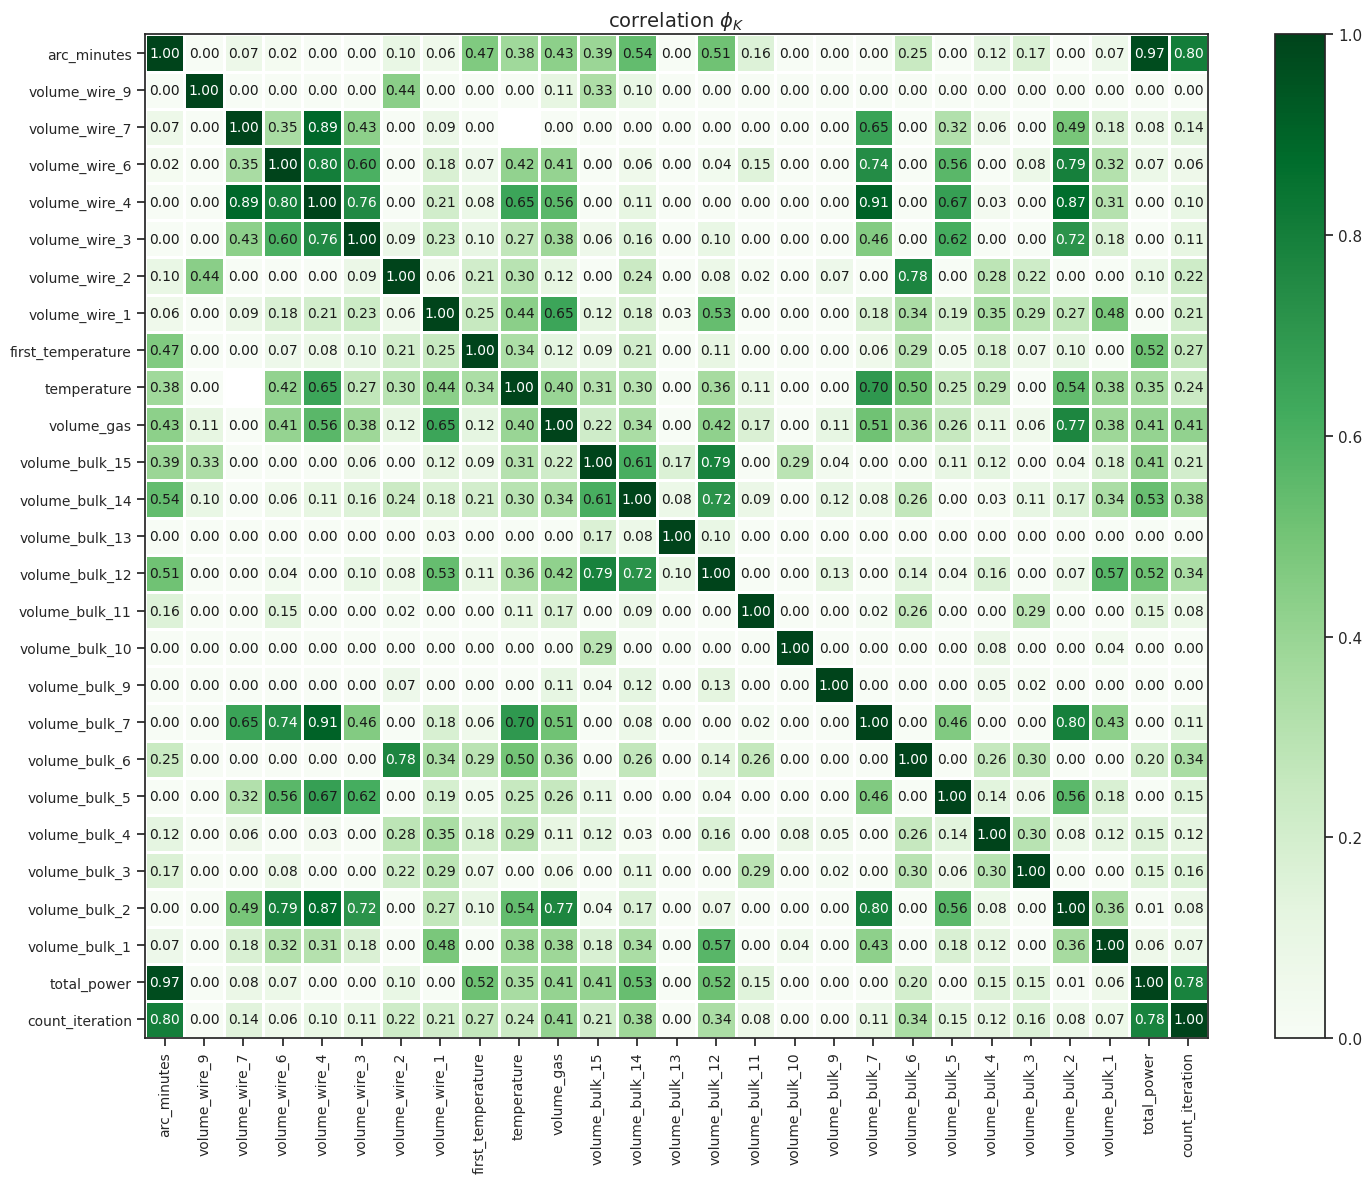

In [118]:
plot_correlation_matrix(phik_overview.values, 
                        x_labels=phik_overview.columns, 
                        y_labels=phik_overview.index, 
                        vmin=0, vmax=1, color_map="Greens", 
                        title=r"correlation $\phi_K$", 
                        fontsize_factor=1, 
                        figsize=(15, 12))
plt.tight_layout()

*Анализ:*
- в отличие от корреляции Пирсона прослеживаются более сильные нелинейные зависимости признаков, например, прослеживается взаимосвязь между различными проволочными и сыпучими материалами - было бы интересно знать, какие конкретно материалы скрываются за численными отображениями;
- между полной мощностью и временем нагрева сплава видна сильная зависимость.

- **исследование данных о сыпучих материалах:**

На графике отображу долю использования сыпучих материалов в партиях и посмотрю, какие из них используются менее чем в 5% партий:

Text(0.5, 0, 'Тип сыпучего материала')

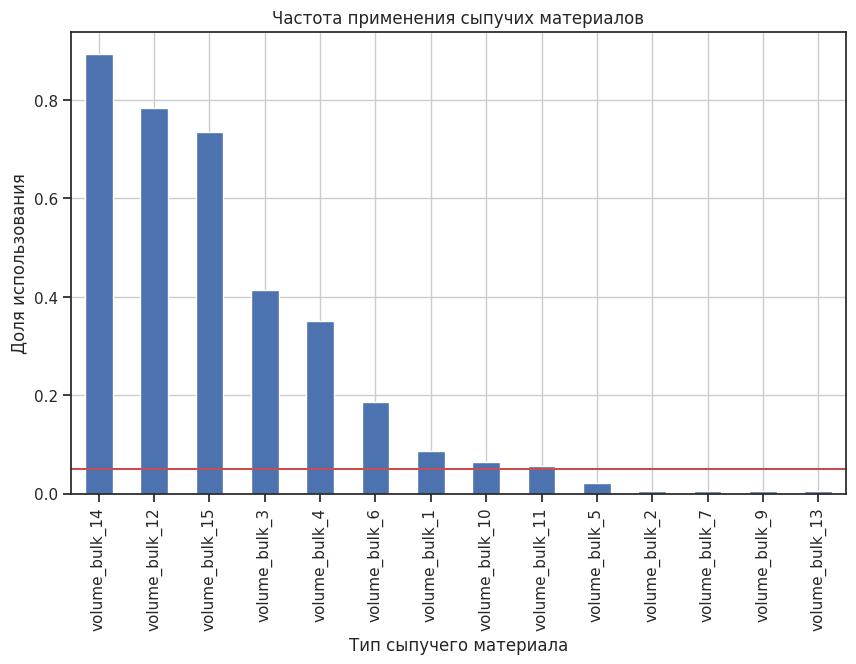

In [68]:
plt.figure(figsize = (10,6))
ax = steel[col_bulk].where(steel[col_bulk] == 0, 1).mean().sort_values(ascending=False).plot(
    kind = 'bar', grid=True
)
ax.axhline(y=0.05, color='r', linestyle='-')
ax.set_title('Частота применения сыпучих материалов')
ax.set_ylabel('Доля использования')
ax.set_xlabel('Тип сыпучего материала')

*Анализ:* почти одна треть сыпучих материалов использовалась менее чем в 5-ти процентах партий.

- **исследование данных о проволочных материалах:**

Также исследую частоту добавления проволочных материалов в каждую партию:

Text(0.5, 0, 'Тип проволочного материала')

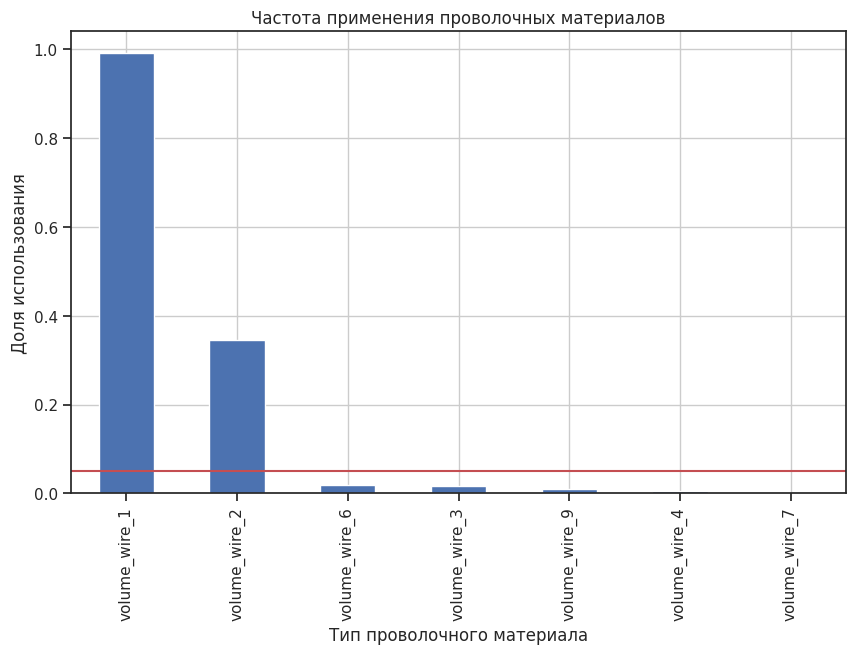

In [69]:
plt.figure(figsize = (10,6))
ax = steel[col_wire].where(steel[col_wire] == 0, 1).mean().sort_values(ascending=False).plot(
    kind = 'bar', grid=True
)
ax.axhline(y=0.05, color='r', linestyle='-')
ax.set_title('Частота применения проволочных материалов')
ax.set_ylabel('Доля использования')
ax.set_xlabel('Тип проволочного материала')

*Анализ:* при легировании стали в каждой партии почти стопроцентно использовался первый проволочный материал `volume_wire_1`, и большая часть проволоки использовалась лишь в 1-2% партий.

- **исследование целевого признака `temperature`:**

In [70]:
steel['temperature'].describe()

count    2250.000000
mean     1593.441778
std        11.170390
min      1541.000000
25%      1587.000000
50%      1593.000000
75%      1598.000000
max      1653.000000
Name: temperature, dtype: float64

Text(0.5, 1.0, 'Гистограмма распределения данных температуры')

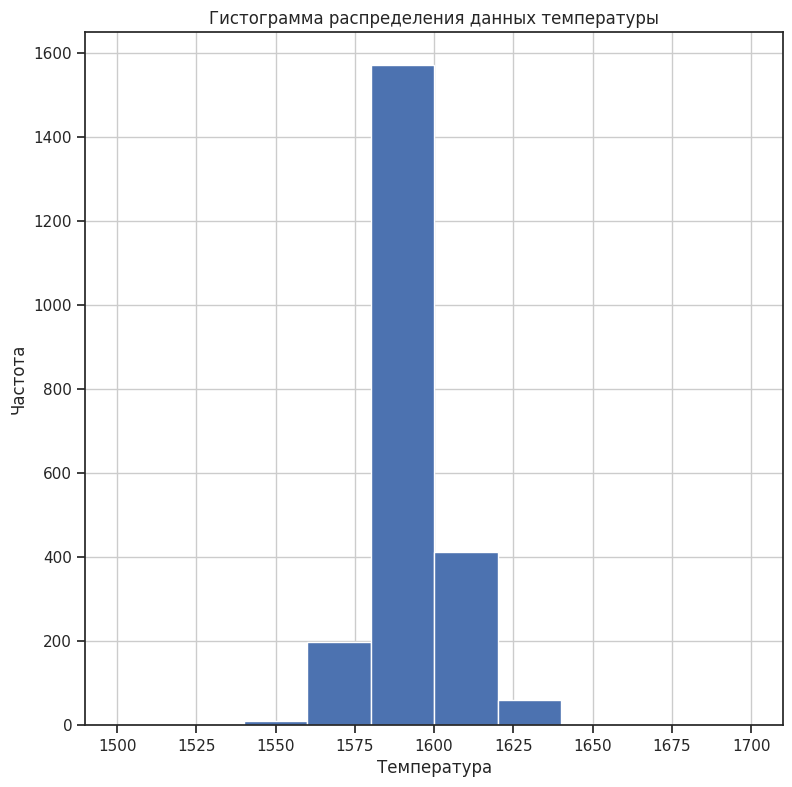

In [71]:
steel['temperature'].hist(range=(1500, 1700))
plt.xlabel('Температура')
plt.ylabel('Частота')
plt.title('Гистограмма распределения данных температуры')

Видны некоторые аномальные значения; выведу их количество и процент от общего числа данных:

In [72]:
steel.query('temperature < 1545 or temperature > 1650')['temperature'].count()

3

In [73]:
# процент аномальных значений
round(steel.query('temperature < 1545 or temperature > 1650')['temperature'].count() * 100 / len(steel), 3)

0.133

Удалю строки с выбивающимися значениями:

In [74]:
steel = steel.query('temperature >= 1545 and temperature <= 1650').reset_index(drop=True)

- **исследование числа итераций в партии `count_iteration`:**

In [75]:
steel['count_iteration'].describe()

count    2247.000000
mean        4.708055
std         1.523997
min         2.000000
25%         4.000000
50%         5.000000
75%         6.000000
max        15.000000
Name: count_iteration, dtype: float64

Text(0.5, 1.0, 'Гистограмма распределения числа итераций в партии')

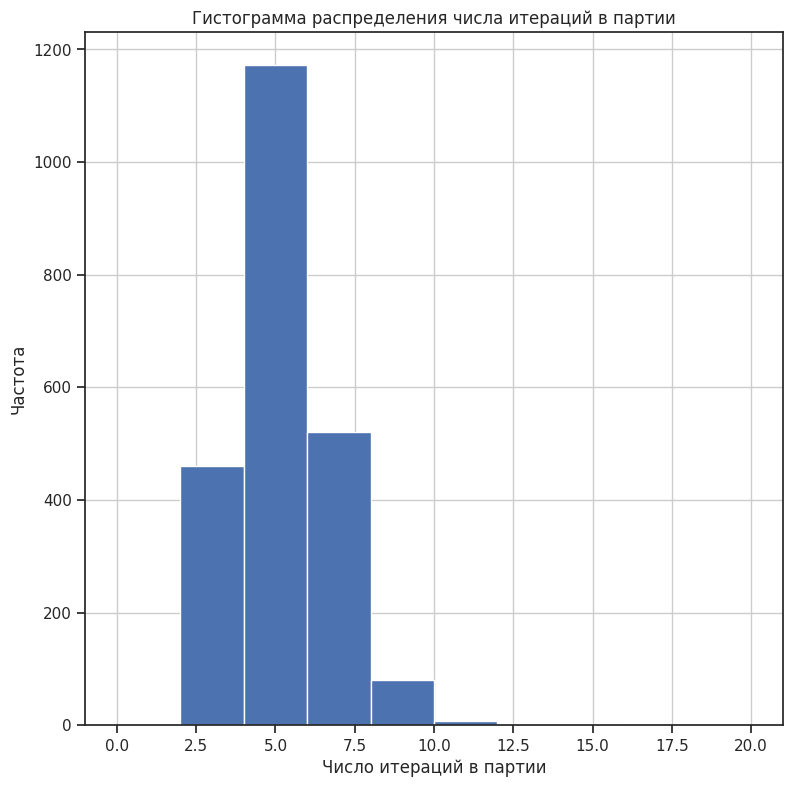

In [76]:
steel['count_iteration'].hist(range=(0, 20))
plt.xlabel('Число итераций в партии')
plt.ylabel('Частота')
plt.title('Гистограмма распределения числа итераций в партии')

In [77]:
steel.query('count_iteration > 13')['count_iteration'].count()

2

In [78]:
# процент аномальных значений
round(steel.query('count_iteration > 13')['count_iteration'].count() * 100 / len(steel), 3)

0.089

In [79]:
steel = steel.query('count_iteration <= 13').reset_index(drop=True)

- **исследование признака продолжительности времени нагрева `arc_minutes`:**

In [80]:
steel['arc_minutes'].describe()

count    2245.000000
mean       13.443630
std         5.282812
min         1.983300
25%         9.766700
50%        12.983300
75%        16.533300
max        45.916700
Name: arc_minutes, dtype: float64

Text(0.5, 1.0, 'Гистограмма распределения продолжительности времени нагрева стали')

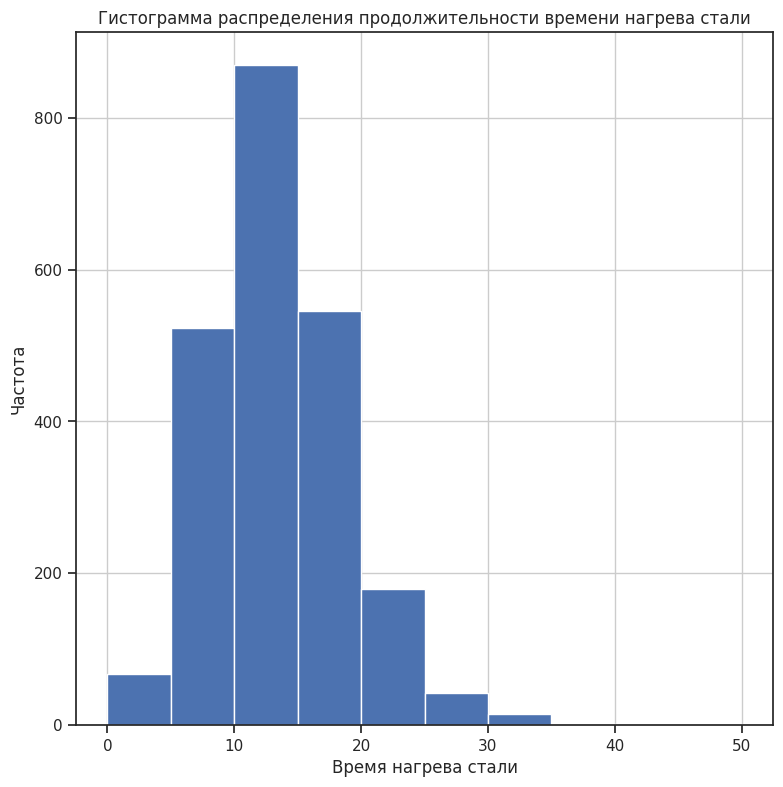

In [81]:
steel['arc_minutes'].hist(range=(0, 50))
plt.xlabel('Время нагрева стали')
plt.ylabel('Частота')
plt.title('Гистограмма распределения продолжительности времени нагрева стали')

Продолжительность нагрева более 35 минут - уже редкие случаи; посмотрю, сколько таких данных и удалю выбивающиеся значения:

In [82]:
steel.query('arc_minutes > 35')['arc_minutes'].count()

3

In [83]:
# процент аномальных значений
round(steel.query('arc_minutes > 35')['arc_minutes'].count() * 100 / len(steel), 3)

0.134

In [84]:
steel = steel.query('arc_minutes <= 35').reset_index(drop=True)

- **исследование полной мощности `total_power`:**

In [85]:
steel['total_power'].describe()

count    2242.000000
mean        4.241891
std        15.149980
min         0.470000
25%         2.760000
50%         3.775000
75%         4.880000
max       717.140000
Name: total_power, dtype: float64

Text(0.5, 1.0, 'Гистограмма распределения полной мощности')

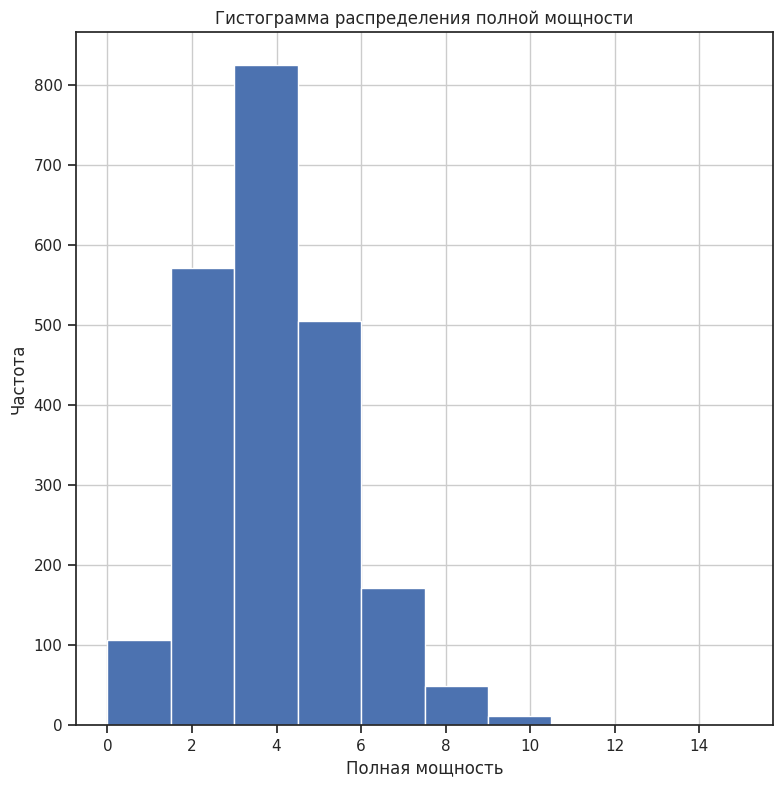

In [86]:
steel['total_power'].hist(range=(0, 15))
plt.xlabel('Полная мощность')
plt.ylabel('Частота')
plt.title('Гистограмма распределения полной мощности')

In [87]:
steel.query('total_power > 10')['total_power'].count()

5

In [88]:
# процент аномальных значений
round(steel.query('total_power > 10')['total_power'].count() * 100 / len(steel), 3)

0.223

In [89]:
steel = steel.query('total_power <= 10').reset_index(drop=True)

In [90]:
steel.describe()

,count_iteration,total_power,volume_bulk_1,volume_bulk_2,volume_bulk_3,volume_bulk_4,volume_bulk_5,volume_bulk_6,volume_bulk_7,volume_bulk_9,volume_bulk_10,volume_bulk_11,volume_bulk_12,volume_bulk_13,volume_bulk_14,volume_bulk_15,volume_gas,temperature,first_temperature,volume_wire_1,volume_wire_2,volume_wire_3,volume_wire_4,volume_wire_6,volume_wire_7,volume_wire_9,arc_minutes
count,2237.000000,2237.000000,2237.000000,2237.000000,2237.000000,2237.000000,2237.000000,2237.000000,2237.000000,2237.000000,2237.000000,2237.000000,2237.000000,2237.000000,2237.000000,2237.000000,2237.000000,2237.000000,2237.000000,2237.000000,2237.000000,2237.000000,2237.000000,2237.000000,2237.000000,2237.000000,2237.000000
mean,4.684399,3.911672,3.359857,1.246759,47.626285,37.514975,2.468038,22.016540,1.503800,0.434958,5.236477,4.232901,208.514975,0.769334,153.690210,120.899866,11.273530,1593.400536,1586.364327,102.108181,17.405454,3.280286,0.240501,0.943228,0.002235,0.297273,13.371308
std,1.467475,1.599927,11.841290,17.829893,75.486590,58.785269,21.910688,55.555901,26.912311,6.207279,21.293501,22.451415,151.898246,11.765238,79.012743,84.065721,6.047162,10.929992,28.281267,42.996733,33.257824,28.350266,4.086312,8.498705,0.105715,3.354523,5.108931
min,2.000000,0.470000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.008400,1545.000000,1191.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.983300
25%,4.000000,2.760000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,105.000000,0.000000,106.000000,0.000000,7.299000,1587.000000,1571.000000,74.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9.766700
50%,5.000000,3.770000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,206.000000,0.000000,149.000000,107.000000,10.088400,1593.000000,1586.000000,101.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,12.966700
75%,6.000000,4.870000,0.000000,0.000000,80.000000,78.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,281.000000,0.000000,204.000000,204.000000,14.133400,1598.000000,1602.000000,127.000000,23.000000,0.000000,0.000000,0.000000,0.000000,0.000000,16.516700
max,12.000000,9.940000,94.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,147.000000,159.000000,313.000000,853.000000,278.000000,428.000000,405.000000,52.142400,1647.000000,1660.000000,330.000000,282.000000,385.000000,113.000000,180.000000,5.000000,62.000000,32.083300


## Разработка модели прогнозирования последней измеренной температуры

### Разделение данных на выборки

In [91]:
features = steel.drop(['temperature'], axis=1)
target = steel['temperature']

In [92]:
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.25, shuffle=True, random_state=SEED
)

In [93]:
# размеры полученных выборок
print(features_train.shape)
print(target_train.shape)
print(features_test.shape)
print(target_test.shape)

(1677, 26)
(1677,)
(560, 26)
(560,)


### Масштабирование количественных признаков

In [94]:
scaler = MinMaxScaler(feature_range = (0,1))

scaler.fit(features_train)
features_train_scaler = scaler.transform(features_train)
features_test_scaler = scaler.transform(features_test)

In [95]:
features_train = pd.DataFrame(
    features_train_scaler, 
    columns=features_train.columns,
    index=features_train.index
)

In [96]:
features_test = pd.DataFrame(
    features_test_scaler, 
    columns=features_test.columns,
    index=features_test.index
)

In [97]:
display(features_train.head())
display(features_test.head())

,count_iteration,total_power,volume_bulk_1,volume_bulk_2,volume_bulk_3,volume_bulk_4,volume_bulk_5,volume_bulk_6,volume_bulk_7,volume_bulk_9,volume_bulk_10,volume_bulk_11,volume_bulk_12,volume_bulk_13,volume_bulk_14,volume_bulk_15,volume_gas,first_temperature,volume_wire_1,volume_wire_2,volume_wire_3,volume_wire_4,volume_wire_6,volume_wire_7,volume_wire_9,arc_minutes
712,0.500,0.399155,0.0,0.0,0.910112,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.179367,0.0,0.348131,0.377778,0.201972,0.844350,0.489286,0.000000,0.0,0.0,0.0,0.0,0.0,0.475638
1884,0.375,0.455121,0.0,0.0,0.000000,0.0,0.0,0.093439,0.0,0.0,0.000000,0.054313,0.295428,0.0,0.453271,0.451852,0.207908,0.837953,0.278571,0.000000,0.0,0.0,0.0,0.0,0.0,0.416392
397,0.375,0.411827,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.238994,0.000000,0.241501,0.0,0.366822,0.380247,0.197950,0.814499,0.321429,0.000000,0.0,0.0,0.0,0.0,0.0,0.478960
533,0.250,0.408659,0.0,0.0,0.000000,0.0,0.0,0.552684,0.0,0.0,0.000000,0.000000,0.241501,0.0,0.357477,0.375309,0.522970,0.844350,0.357143,0.000000,0.0,0.0,0.0,0.0,0.0,0.467887
1665,0.500,0.430834,0.0,0.0,0.519101,0.0,0.0,0.000000,0.0,0.0,0.000000,0.102236,0.240328,0.0,0.228972,0.506173,0.251922,0.865672,0.489286,0.031915,0.0,0.0,0.0,0.0,0.0,0.457365


,count_iteration,total_power,volume_bulk_1,volume_bulk_2,volume_bulk_3,volume_bulk_4,volume_bulk_5,volume_bulk_6,volume_bulk_7,volume_bulk_9,volume_bulk_10,volume_bulk_11,volume_bulk_12,volume_bulk_13,volume_bulk_14,volume_bulk_15,volume_gas,first_temperature,volume_wire_1,volume_wire_2,volume_wire_3,volume_wire_4,volume_wire_6,volume_wire_7,volume_wire_9,arc_minutes
1726,0.375,0.336853,0.000000,0.0,0.000000,0.000000,0.0,0.186879,0.0,0.0,0.0,0.0,0.000000,0.0,0.698598,0.000000,0.327959,0.876333,0.171429,0.000000,0.0,0.0,0.000000,0.0,0.0,0.401442
18,0.375,0.334741,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.581776,0.000000,0.191796,0.833689,0.375000,0.255319,0.0,0.0,0.000000,0.0,0.0,0.341086
701,0.250,0.189018,0.000000,0.0,0.000000,0.526690,0.0,0.000000,0.0,0.0,0.0,0.0,0.420868,0.0,0.474299,0.279012,0.157062,0.931770,0.428571,0.067376,0.0,0.0,0.000000,0.0,0.0,0.198229
1976,0.500,0.518479,0.329787,0.0,0.233708,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.566237,0.0,0.287383,0.558025,0.187650,0.850746,0.525000,0.000000,0.0,0.0,0.211111,0.0,0.0,0.503322
1841,0.000,0.052798,0.000000,0.0,0.000000,0.505338,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.229242,0.968017,0.514286,0.095745,0.0,0.0,0.000000,0.0,0.0,0.058694


### Подбор гиперпараметров с optuna

In [98]:
def search_best_params(model, params):
    optuna_cv = OptunaSearchCV(
        model,
        params,
        cv=5,
        scoring='neg_mean_absolute_error',
        n_trials=100,
        n_jobs=-1, 
        verbose=1, 
        random_state=SEED
    )
    optuna_cv.fit(features_train, target_train)
    return optuna_cv

**RandomForestRegressor**

In [99]:
# %%time
    
# params = {
#     "n_estimators": optuna.distributions.IntDistribution(50, 800, log=True),
#     "max_depth": optuna.distributions.IntDistribution(3, 7),
#     "min_samples_split": optuna.distributions.IntDistribution(2, 4),
#     "min_samples_leaf": optuna.distributions.IntDistribution(1, 3)
# }
    
# rfr = RandomForestRegressor(random_state=SEED)

# result = search_best_params(rfr, params)

In [100]:
# result.study_.best_trial

**FrozenTrial(number=94, values=[-6.006403258122693], datetime_start=datetime.datetime(2023, 1, 10, 20, 53, 36, 921178), datetime_complete=datetime.datetime(2023, 1, 10, 20, 54, 54, 885041), params={'n_estimators': 758, 'max_depth': 7, 'min_samples_split': 3, 'min_samples_leaf': 3}, distributions={'n_estimators': IntDistribution(high=800, log=True, low=50, step=1), 'max_depth': IntDistribution(high=7, log=False, low=3, step=1), 'min_samples_split': IntDistribution(high=4, log=False, low=2, step=1), 'min_samples_leaf': IntDistribution(high=3, log=False, low=1, step=1)}, user_attrs={'mean_fit_time': 15.115757846832276, 'std_fit_time': 1.977258893535659, 'mean_score_time': 0.4692100524902344, 'std_score_time': 0.07742570375616871, 'split0_test_score': -6.655362293880636, 'split1_test_score': -5.993754268434687, 'split2_test_score': -5.857842507222791, 'split3_test_score': -5.585612948853949, 'split4_test_score': -5.939444272221401, 'mean_test_score': -6.006403258122693, 'std_test_score': 0.3535324918327488}, system_attrs={}, intermediate_values={}, trial_id=94, state=TrialState.COMPLETE, value=None)**

**GradientBoostingRegressor**

In [101]:
# %%time
    
# params = {
#     "learning_rate": optuna.distributions.FloatDistribution(0.00001, 0.01, log=True),
#     "n_estimators": optuna.distributions.IntDistribution(50, 800, log=True),
#     "max_depth": optuna.distributions.IntDistribution(3, 7),
#     "min_samples_split": optuna.distributions.IntDistribution(2, 4),
#     "min_samples_leaf": optuna.distributions.IntDistribution(1, 3),
#     "tol": optuna.distributions.FloatDistribution(0.0001, 0.01, log=True)
# }
    
# gbr = GradientBoostingRegressor(random_state=SEED)

# result = search_best_params(gbr, params)

In [102]:
# result.study_.best_trial

**FrozenTrial(number=80, values=[-5.9004764888090975], datetime_start=datetime.datetime(2023, 1, 10, 20, 57, 42, 807555), datetime_complete=datetime.datetime(2023, 1, 10, 20, 58, 13, 734612), params={'learning_rate': 0.00970724738478562, 'n_estimators': 695, 'max_depth': 4, 'min_samples_split': 3, 'min_samples_leaf': 2, 'tol': 0.00659450244060012}, distributions={'learning_rate': FloatDistribution(high=0.01, log=True, low=1e-05, step=None), 'n_estimators': IntDistribution(high=800, log=True, low=50, step=1), 'max_depth': IntDistribution(high=7, log=False, low=3, step=1), 'min_samples_split': IntDistribution(high=4, log=False, low=2, step=1), 'min_samples_leaf': IntDistribution(high=3, log=False, low=1, step=1), 'tol': FloatDistribution(high=0.01, log=True, low=0.0001, step=None)}, user_attrs={'mean_fit_time': 6.169391441345215, 'std_fit_time': 0.3322943581364233, 'mean_score_time': 0.008617019653320313, 'std_score_time': 0.0014194875942285465, 'split0_test_score': -6.336563758211704, 'split1_test_score': -5.878662882755189, 'split2_test_score': -5.6120801447469, 'split3_test_score': -5.6485959618769135, 'split4_test_score': -6.02647969645478, 'mean_test_score': -5.9004764888090975, 'std_test_score': 0.2657596656368959}, system_attrs={}, intermediate_values={}, trial_id=80, state=TrialState.COMPLETE, value=None)**

**LGBMRegressor**

In [103]:
# %%time

# params = {
#     "n_estimators":  optuna.distributions.IntDistribution(50, 800, log=True),
#     "max_depth":  optuna.distributions.IntDistribution(3, 7),
#     "learning_rate":  optuna.distributions.FloatDistribution(0.001, 0.01, log=True)
# }
# lgbm = lgb.LGBMRegressor(random_state=SEED)


# result = search_best_params(lgbm, params)

In [104]:
# result.study_.best_trial

**FrozenTrial(number=60, values=[-5.925011107671959], datetime_start=datetime.datetime(2023, 1, 10, 21, 1, 51, 716451), datetime_complete=datetime.datetime(2023, 1, 10, 21, 2, 47, 106966), params={'n_estimators': 633, 'max_depth': 5, 'learning_rate': 0.008345191264842827}, distributions={'n_estimators': IntDistribution(high=800, log=True, low=50, step=1), 'max_depth': IntDistribution(high=7, log=False, low=3, step=1), 'learning_rate': FloatDistribution(high=0.01, log=True, low=0.001, step=None)}, user_attrs={'mean_fit_time': 11.052043104171753, 'std_fit_time': 0.8327674549615797, 'mean_score_time': 0.016824865341186525, 'std_score_time': 0.003604154280456314, 'split0_test_score': -6.41196126768466, 'split1_test_score': -5.881838193271734, 'split2_test_score': -5.695752044380046, 'split3_test_score': -5.552162624751889, 'split4_test_score': -6.083341408271464, 'mean_test_score': -5.925011107671959, 'std_test_score': 0.30187035372140025}, system_attrs={}, intermediate_values={}, trial_id=60, state=TrialState.COMPLETE, value=None)**

**KNeighborsRegressor**

In [105]:
# %%time
    
# params = {
#     "n_neighbors": optuna.distributions.IntDistribution(1, 50, log=True),
#     'weights': optuna.distributions.CategoricalDistribution(['uniform', 'distance']),
#     'algorithm': optuna.distributions.CategoricalDistribution(['auto', 'ball_tree', 'kd_tree', 'brute'])
# }
    
# knr = KNeighborsRegressor()

# result = search_best_params(knr, params)

[I 2023-01-10 21:10:36,660] A new study created in memory with name: no-name-6f05eedc-54a0-48ec-84c0-101dc2c68fe5
[I 2023-01-10 21:10:36,661] Searching the best hyperparameters using 1677 samples...
[I 2023-01-10 21:10:36,917] Trial 9 finished with value: -8.80428393745558 and parameters: {'n_neighbors': 1, 'weights': 'uniform', 'algorithm': 'ball_tree'}. Best is trial 9 with value: -8.80428393745558.
[I 2023-01-10 21:10:36,920] Trial 5 finished with value: -7.846539623312012 and parameters: {'n_neighbors': 2, 'weights': 'uniform', 'algorithm': 'kd_tree'}. Best is trial 5 with value: -7.846539623312012.
[I 2023-01-10 21:10:36,926] Trial 2 finished with value: -7.050524831201136 and parameters: {'n_neighbors': 8, 'weights': 'uniform', 'algorithm': 'kd_tree'}. Best is trial 2 with value: -7.050524831201136.
[I 2023-01-10 21:10:36,983] Trial 8 finished with value: -6.949780836551289 and parameters: {'n_neighbors': 9, 'weights': 'distance', 'algorithm': 'kd_tree'}. Best is trial 8 with val

CPU times: user 15.2 s, sys: 4.2 s, total: 19.4 s
Wall time: 5 s


In [106]:
# result.study_.best_trial

FrozenTrial(number=36, values=[-6.861968617016549], datetime_start=datetime.datetime(2023, 1, 10, 21, 10, 38, 377405), datetime_complete=datetime.datetime(2023, 1, 10, 21, 10, 38, 964377), params={'n_neighbors': 25, 'weights': 'distance', 'algorithm': 'brute'}, distributions={'n_neighbors': IntDistribution(high=50, log=True, low=1, step=1), 'weights': CategoricalDistribution(choices=('uniform', 'distance')), 'algorithm': CategoricalDistribution(choices=('auto', 'ball_tree', 'kd_tree', 'brute'))}, user_attrs={'mean_fit_time': 0.01571049690246582, 'std_fit_time': 0.007647557951527773, 'mean_score_time': 0.09135203361511231, 'std_score_time': 0.020737037145556098, 'split0_test_score': -7.446444277208495, 'split1_test_score': -6.901420422401987, 'split2_test_score': -6.661482342667274, 'split3_test_score': -6.6125897097855635, 'split4_test_score': -6.687906333019424, 'mean_test_score': -6.861968617016549, 'std_test_score': 0.30849651751339124}, system_attrs={}, intermediate_values={}, tria

**FrozenTrial(number=36, values=[-6.861968617016549], datetime_start=datetime.datetime(2023, 1, 10, 21, 10, 38, 377405), datetime_complete=datetime.datetime(2023, 1, 10, 21, 10, 38, 964377), params={'n_neighbors': 25, 'weights': 'distance', 'algorithm': 'brute'}, distributions={'n_neighbors': IntDistribution(high=50, log=True, low=1, step=1), 'weights': CategoricalDistribution(choices=('uniform', 'distance')), 'algorithm': CategoricalDistribution(choices=('auto', 'ball_tree', 'kd_tree', 'brute'))}, user_attrs={'mean_fit_time': 0.01571049690246582, 'std_fit_time': 0.007647557951527773, 'mean_score_time': 0.09135203361511231, 'std_score_time': 0.020737037145556098, 'split0_test_score': -7.446444277208495, 'split1_test_score': -6.901420422401987, 'split2_test_score': -6.661482342667274, 'split3_test_score': -6.6125897097855635, 'split4_test_score': -6.687906333019424, 'mean_test_score': -6.861968617016549, 'std_test_score': 0.30849651751339124}, system_attrs={}, intermediate_values={}, trial_id=36, state=TrialState.COMPLETE, value=None)**

### Обучение моделей

Для нахождения последней измеренной температуры стали обучу следующие модели:
- LinearRegressor
- RandomForestRegressor
- GradientBoostingRegressor
- LGBMRegressor
- KNeighborsRegressor
- Полносвязная нейронная сеть

- ***LinearRegression***

In [120]:
lr_model = LinearRegression()

In [121]:
%%time

scores = cross_val_score(
    lr_model, features_train, target_train, cv=5, scoring='neg_mean_absolute_error'
)
scores = abs(scores)
print('Средняя оценка качества модели: %.2f (%.2f)' % (scores.mean(), scores.std()))

Средняя оценка качества модели: 6.26 (0.32)
CPU times: user 29.2 ms, sys: 696 µs, total: 29.9 ms
Wall time: 36.8 ms


**Средняя оценка качества модели: 6.26 (0.32)**

- ***RandomForestRegressor***

In [122]:
params = {'n_estimators': 758, 'max_depth': 7, 'min_samples_split': 3, 'min_samples_leaf': 3}

rf_model = RandomForestRegressor(
    **params, 
    random_state=SEED,
    n_jobs=-1
)

In [123]:
%%time

scores = cross_val_score(
    rf_model, features_train, target_train, cv=5, scoring='neg_mean_absolute_error'
)
scores = abs(scores)
print('Средняя оценка качества модели: %.2f (%.2f)' % (scores.mean(), scores.std()))

Средняя оценка качества модели: 6.01 (0.35)
CPU times: user 2.4 s, sys: 241 ms, total: 2.65 s
Wall time: 4.69 s


**Средняя оценка качества модели: 6.01 (0.35)**

- ***GradientBoostingRegressor***

In [124]:
params = {
    'learning_rate': 0.00970724738478562,
    'n_estimators': 695,
    'max_depth': 4,
    'min_samples_split': 3,
    'min_samples_leaf': 2,
    'tol': 0.00659450244060012
}

gb_model = GradientBoostingRegressor(
    **params,
    random_state=SEED
)

In [125]:
%%time

scores = cross_val_score(
    gb_model, features_train, target_train, cv=5, scoring='neg_mean_absolute_error'
)
scores = abs(scores)
print('Средняя оценка качества модели: %.2f (%.2f)' % (scores.mean(), scores.std()))

Средняя оценка качества модели: 5.90 (0.27)
CPU times: user 9.74 s, sys: 0 ns, total: 9.74 s
Wall time: 9.74 s


**Средняя оценка качества модели: 5.90 (0.27)**

- ***LGBMRegressor***

In [126]:
train_dataset = lgb.Dataset(
    features_train, label=target_train
)
test_dataset = lgb.Dataset(
    features_test, label=target_test
)

In [127]:
%%time

params = {'n_estimators': 633, 'max_depth': 5, 'learning_rate': 0.008345191264842827}
params |= {"objective": "mae", "verbosity": -1, 'random_state': SEED}

cv_output = lgb.cv(
    params,
    train_set=train_dataset, num_boost_round=200,
    metrics=["mae"],
    nfold=5,
    stratified=False,
    return_cvbooster=True,
)

CPU times: user 15.4 s, sys: 166 ms, total: 15.6 s
Wall time: 1.31 s


In [128]:
best_value = np.min(cv_output['l1-mean'])
best_iter = np.argmin(cv_output['l1-mean'])
print("Средняя оценка качества модели: {:.2f}+/-{:.2f} on step {}".format(
best_value, cv_output['l1-mean'][best_iter], best_iter)
     )

Средняя оценка качества модели: 5.94+/-5.94 on step 628


**Средняя оценка качества модели: 5.94+/-5.94 on step 628**

- ***KNeighborsRegressor***

In [129]:
params = {'n_neighbors': 25, 'weights': 'distance', 'algorithm': 'brute'}
knr_model = KNeighborsRegressor(**params)

In [130]:
%%time

scores = cross_val_score(
    knr_model, features_train, target_train, cv=5, scoring='neg_mean_absolute_error'
)
scores = abs(scores)
print('Средняя оценка качества модели: %.2f (%.2f)' % (scores.mean(), scores.std()))

Средняя оценка качества модели: 6.86 (0.31)
CPU times: user 1.73 s, sys: 495 ms, total: 2.22 s
Wall time: 202 ms


**Средняя оценка качества модели: 6.86 (0.31)**

- ***Полносвязная нейронная сеть***

In [128]:
def create_model(input_shape):
    optimizer = Adam(learning_rate=0.0001)
    model = Sequential()
    model.add(Dense(input_shape[0], activation='relu', input_shape=input_shape))
    model.add(Dense(40, activation='relu'))
    model.add(Dense(10, activation='relu'))
    model.add(Dense(5, activation='relu'))
    model.add(Dense(2, activation='relu'))
    model.add(Dense(1, activation='relu'))
    
    model.build()
    model.compile(
        optimizer=optimizer, 
        loss='mse',
        metrics=['mae']
    )
    print(model.summary())
    
    return model

In [129]:
neuro_model = create_model((features_train.shape[1], ))

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_18 (Dense)            (None, 26)                702       
                                                                 
 dense_19 (Dense)            (None, 40)                1080      
                                                                 
 dense_20 (Dense)            (None, 10)                410       
                                                                 
 dense_21 (Dense)            (None, 5)                 55        
                                                                 
 dense_22 (Dense)            (None, 2)                 12        
                                                                 
 dense_23 (Dense)            (None, 1)                 3         
                                                                 
Total params: 2,262
Trainable params: 2,262
Non-traina

In [130]:
callback = EarlyStopping(monitor='loss', patience=5)

In [131]:
neuro_model.fit(
  features_train,
  target_train,
  epochs=1500,
  callbacks=[callback],
  verbose=1
)

Epoch 1/1500
53/53 [==============================] - 1s 1ms/step - loss: 2538400.5000 - mae: 1593.1993
Epoch 2/1500
53/53 [==============================] - 0s 1ms/step - loss: 2538320.0000 - mae: 1593.1743
Epoch 3/1500
53/53 [==============================] - 0s 1ms/step - loss: 2538203.7500 - mae: 1593.1379
Epoch 4/1500
53/53 [==============================] - 0s 1ms/step - loss: 2538052.7500 - mae: 1593.0908
Epoch 5/1500
53/53 [==============================] - 0s 1ms/step - loss: 2537851.7500 - mae: 1593.0276
Epoch 6/1500
53/53 [==============================] - 0s 968us/step - loss: 2537563.5000 - mae: 1592.9368
Epoch 7/1500
53/53 [==============================] - 0s 1ms/step - loss: 2537099.2500 - mae: 1592.7915
Epoch 8/1500
53/53 [==============================] - 0s 1ms/step - loss: 2536362.2500 - mae: 1592.5601
Epoch 9/1500
53/53 [==============================] - 0s 977us/step - loss: 2535288.7500 - mae: 1592.2228
Epoch 10/1500
53/53 [==============================] - 0s 1m

**Значение MAE для модели нейронной сети: 6.1017**

### Вывод

По результатам обучения на трейне лучшей стала модель **GradientBoostingRegressor** с ключевым значением метрики MAE = 5.90.

## Проверка наилучшей модели на тестовой выборке

In [136]:
params = {
    'learning_rate': 0.00970724738478562,
    'n_estimators': 695,
    'max_depth': 4,
    'min_samples_split': 3,
    'min_samples_leaf': 2,
    'tol': 0.00659450244060012
}

gb_model = GradientBoostingRegressor(
    **params,
    random_state=SEED
)

gb_model.fit(features_train, target_train)
mae = mean_absolute_error(target_test, gb_model.predict(features_test))
print('Значение MAE на тестовой выборке для модели градиентного бустинга:', round(mae, 2))

Значение MAE на тестовой выборке для модели градиентного бустинга: 6.08


### Вывод

Результат обучения модели **GradientBoostingRegressor на тестовой выборке: ключевая метрика MAE = 6.08**.

## Анализ важности признаков

### Features importance

Чтобы посмотреть какие признаки влияют на обучение модели выведу градацию признаков по важности:

In [133]:
def print_features_importance(model, column_names):
    feats = {}
    for feature, importance in zip(column_names, model.feature_importances_):
        feats[feature] = importance
    importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-Importance'})
    importances = importances.sort_values(by='Gini-Importance', ascending=False)
    importances = importances.reset_index()
    importances = importances.rename(columns={'index': 'Features'})
    sns.set(font_scale = 5)
    sns.set(style="whitegrid", color_codes=True, font_scale = 1.7)
    fig, ax = plt.subplots()
    fig.set_size_inches(12, 12)
    sns.barplot(x=importances['Gini-Importance'], y=importances['Features'], data=importances, color='lightgreen')
    plt.xlabel('Importance', fontsize=15, weight = 'bold')
    plt.ylabel('Features', fontsize=15, weight = 'bold')
    plt.title(f'Features Importance for {model.__class__.__name__}', fontsize=15, weight = 'bold')
    display(plt.show())

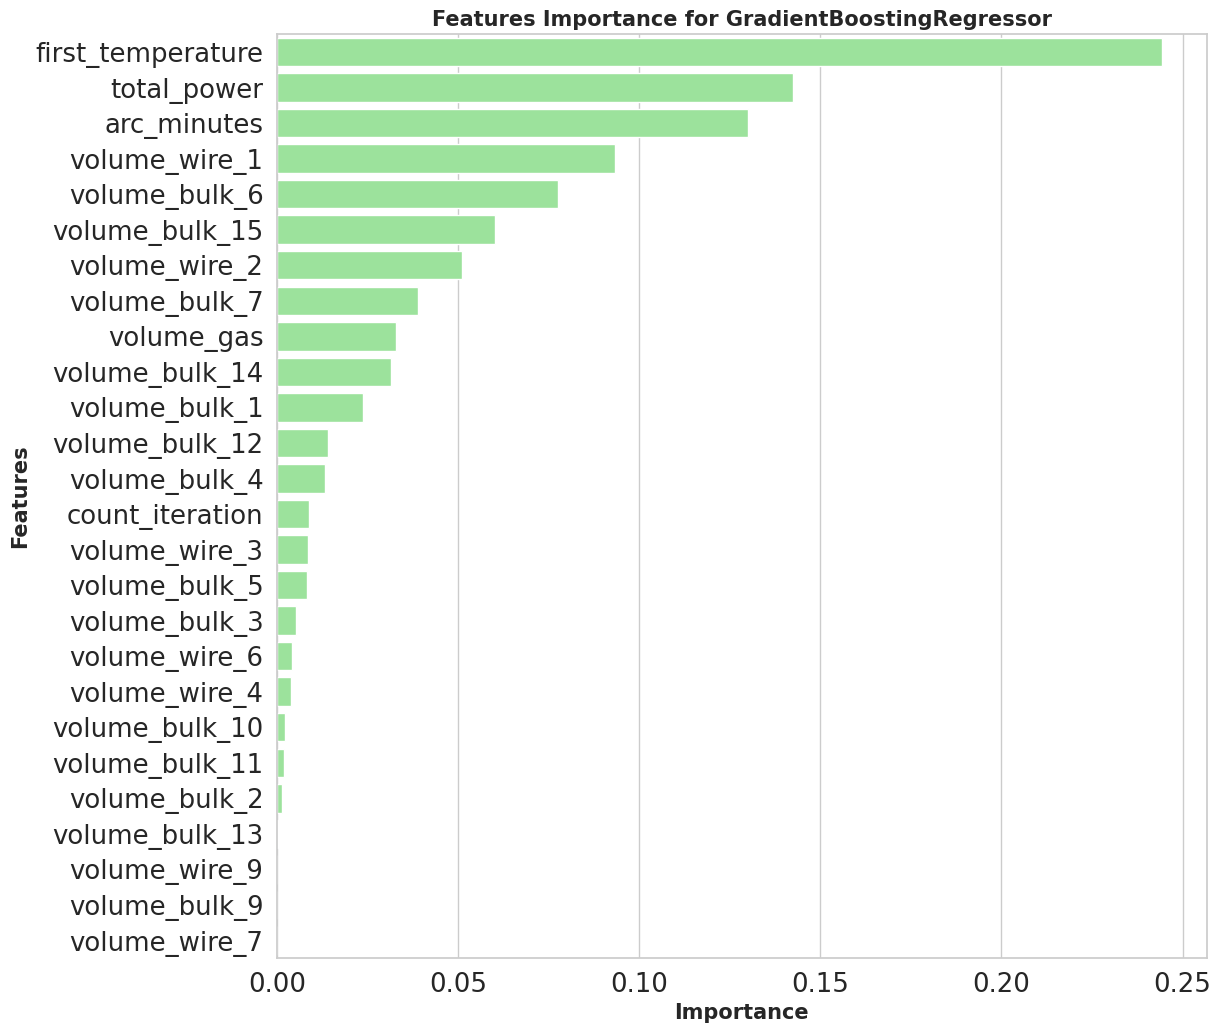

None

In [134]:
print_features_importance(gb_model, features_train.columns)

*Анализ:* наиболее важными признаками для модели LGBMRegressor являются значение первой измеренной температуры стали, полное значение мощности нагрева графитовыми электодами и суммарное время нагрева сплава. 

- **график зависимости целевой переменной и значением первой измеренной температуры:**

Text(0, 0.5, 'temperature')

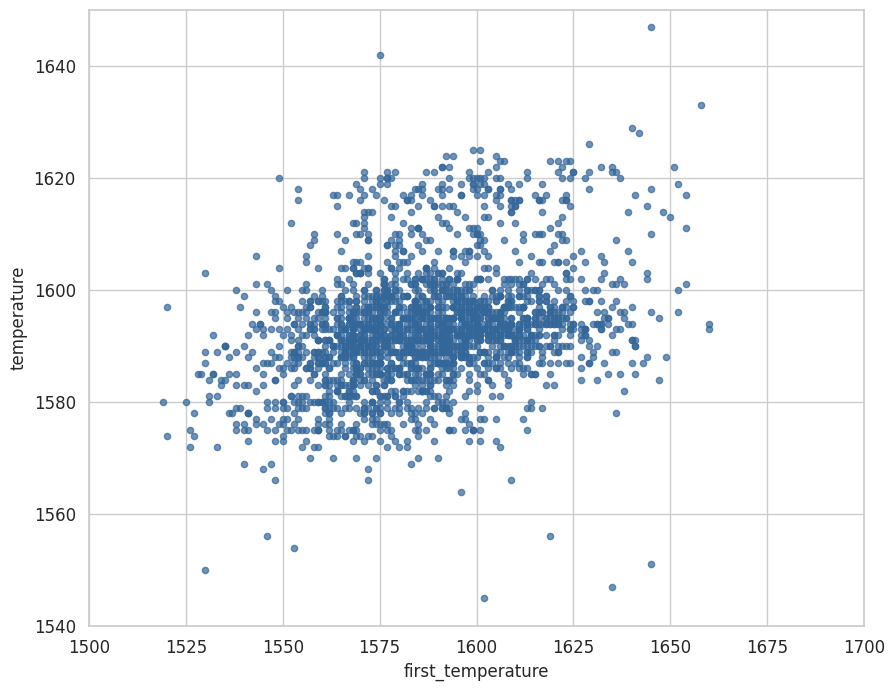

In [135]:
color = np.array([.2, .4, .6])
ax = steel.plot(
    kind='scatter', y='temperature', x='first_temperature', 
    grid=True, ylim=(1540,1650), xlim=(1500,1700), alpha=0.7, figsize=(10,8), fontsize=12, c=np.atleast_2d(color)
)
ax.set_xlabel('first_temperature', fontsize=12)
ax.set_ylabel('temperature', fontsize=12)

*Анализ:* по концентрации точек видно, что зависимость есть, но она явно не описывается простой функцией; также наблюдаются партии, в которых сплав стали перегревали.

## Итоговые выводы по проекту

Результаты работы разных моделей:

| Модель                      | MAE на train | 
|-----------------------------|--------------|
| LinearRegressor             |      6.26    |
| RandomForestRegressor       |      6.01    |
| GradientBoostingRegressor   |      5.90    |
| LGBMRegressor               |      5.94    |
| KNeighborsRegressor         |      6.86    |
| Полносвязная нейронная сеть |      6.10    |

Решена задача регрессии по предсказанию последней измеренной температуры сплава стали. 
- в ходе статистического анализа данных выявлены некорректно заполненные данные: в столбцах со временем измерения не хватает информации о текущей дате;
- в процессе создания датафрейма объединены таблицы, созданы новые и агрегированы имеющиеся признаки для обучения; обработаны пропущенные значения;
- с помощью исследовательского анализа удалось отследить аномальные выбивающиеся значения и избавиться от них; также выявлено, что из 15 сыпучих материалов и 9 проволочных лишь одна треть использовалась в большистве партий; остальные же - только в 5-ти процентах партиях.
- подобраны гиперпараметры и обучены 6 моделей регрессии, в том числе полносвязная нейронная сеть, в результате лучшей моделью стала **GradientBoostingRegressor с ключевым значением метрики MAE = 6.09 на тестовой выборке**;
- наиболее важными признаками в результате анализа методом feature importance стали полное значение мощности нагрева графитовыми электодами, суммарное время нагрева сплава и значение первой измеренной температуры стали.